In [1]:
import pandas as pd
import numpy as np
import pickle
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('spam detection.csv')

In [4]:
display(Markdown("### Dataset Overview"))
print(f"Total messages: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

### Dataset Overview

Total messages: 279
Columns: ['ham', "Can you help me with the math homework? I'm stuck on question 5", 'Unnamed: 2', 'Unnamed: 3']


In [5]:
display(df.head())

,ham,Can you help me with the math homework? I'm stuck on question 5,Unnamed: 2,Unnamed: 3
0,ham,I'll be 10 minutes late to the meeting. Traffi...,NaN,NaN
1,ham,Your prescription refill is ready at the pharmacy,NaN,NaN
2,ham,The concert tickets just went on sale. Should ...,NaN,NaN
3,ham,Don't forget to water the plants while I'm away,NaN,NaN
4,ham,The software update is ready to install on you...,NaN,NaN


In [6]:
display(Markdown("### Dataset Overview"))
print(f"Total messages: {len(df)}")
print(f"Columns found: {df.columns.tolist()}")
print(f"First few rows:")
display(df.head())


### Dataset Overview

Total messages: 279
Columns found: ['ham', "Can you help me with the math homework? I'm stuck on question 5", 'Unnamed: 2', 'Unnamed: 3']
First few rows:


,ham,Can you help me with the math homework? I'm stuck on question 5,Unnamed: 2,Unnamed: 3
0,ham,I'll be 10 minutes late to the meeting. Traffi...,NaN,NaN
1,ham,Your prescription refill is ready at the pharmacy,NaN,NaN
2,ham,The concert tickets just went on sale. Should ...,NaN,NaN
3,ham,Don't forget to water the plants while I'm away,NaN,NaN
4,ham,The software update is ready to install on you...,NaN,NaN


In [7]:
display(Markdown("### Column Information"))
print("Column names and sample values:")
for col in df.columns:
    print(f"  - '{col}': {df[col].iloc[0][:50] if pd.notna(df[col].iloc[0]) else 'NaN'}")


### Column Information

Column names and sample values:
  - 'ham': ham
  - 'Can you help me with the math homework? I'm stuck on question 5': I'll be 10 minutes late to the meeting. Traffic is
  - 'Unnamed: 2': NaN
  - 'Unnamed: 3': NaN


In [8]:
label_col = None
text_col = None


In [9]:
for col in df.columns:
    col_lower = col.lower()
    
    # Check for label column
    if label_col is None:
        if any(keyword in col_lower for keyword in ['label', 'type', 'category', 'class', 'target']):
            label_col = col
        # Also check by values
        elif df[col].dropna().astype(str).str.lower().isin(['ham', 'spam', '0', '1', 'legit', 'fraud']).any():
            label_col = col
    
    # Check for text column
    if text_col is None:
        if any(keyword in col_lower for keyword in ['text', 'message', 'sms', 'email', 'content', 'body']):
            text_col = col
        # Also check by content (long strings)
        elif df[col].astype(str).str.len().mean() > 20:  # If average length > 20 chars
            text_col = col


In [10]:
if label_col is None and len(df.columns) >= 2:
    label_col = df.columns[0]
    text_col = df.columns[1]
    print(f" Using default: '{label_col}' as label, '{text_col}' as text")

In [11]:
print(f" Identified columns:")
print(f"   Label column: '{label_col}'")
print(f"   Text column: '{text_col}'")

 Identified columns:
   Label column: 'ham'
   Text column: 'Can you help me with the math homework? I'm stuck on question 5'


In [12]:
df = df.rename(columns={label_col: 'label', text_col: 'text'})

In [13]:
display(Markdown("### Sample Data After Renaming"))
display(df[['label', 'text']].head())

### Sample Data After Renaming

,label,text
0,ham,I'll be 10 minutes late to the meeting. Traffi...
1,ham,Your prescription refill is ready at the pharmacy
2,ham,The concert tickets just went on sale. Should ...
3,ham,Don't forget to water the plants while I'm away
4,ham,The software update is ready to install on you...


In [14]:
df['label'] = df['label'].astype(str).str.lower().str.strip()

In [15]:
print(f"Unique labels found: {df['label'].unique()[:10]}")

Unique labels found: ['ham' 'spam']


In [16]:
label_mapping = {
    # Standard formats
    'ham': 0, 'spam': 1,
    # Numeric formats
    '0': 0, '1': 1,
    # Variations
    'legitimate': 0, 'legit': 0, 'good': 0,
    'fraud': 1, 'bad': 1, 'malicious': 1,
    'not spam': 0, 'nospam': 0,
    'yes': 1, 'no': 0
}

In [17]:
def map_label(label):
    label_str = str(label).lower().strip()
    
    # First try exact match
    if label_str in label_mapping:
        return label_mapping[label_str]
    
    # Try partial matches
    if 'ham' in label_str:
        return 0
    elif 'spam' in label_str:
        return 1
    elif label_str in ['0', 'false', 'no', 'negative']:
        return 0
    elif label_str in ['1', 'true', 'yes', 'positive']:
        return 1
    else:
        return None

In [18]:
# Apply mapping
df['label_binary'] = df['label'].apply(map_label)

In [19]:
# Check for unmapped labels
unmapped = df[df['label_binary'].isna()]
if not unmapped.empty:
    print(f"Warning: {len(unmapped)} labels could not be mapped:")
    print(f"   Unique unmapped labels: {unmapped['label'].unique()[:10]}")
    print("   These rows will be dropped.")


In [20]:
# Remove rows with unknown labels
df = df.dropna(subset=['label_binary'])
df['label_binary'] = df['label_binary'].astype(int)


In [21]:
# Clean text (basic cleaning)
df['text'] = df['text'].astype(str).str.strip()


In [22]:
df = df[df['text'].str.len() > 0]


In [23]:
# Display distribution
display(Markdown("### Class Distribution"))
ham_count = df[df['label_binary'] == 0].shape[0]
spam_count = df[df['label_binary'] == 1].shape[0]

print(f"Ham messages: {ham_count} ({ham_count/len(df)*100:.1f}%)")
print(f"Spam messages: {spam_count} ({spam_count/len(df)*100:.1f}%)")
print(f"Total after cleaning: {len(df)} messages")


### Class Distribution

Ham messages: 189 (67.7%)
Spam messages: 90 (32.3%)
Total after cleaning: 279 messages


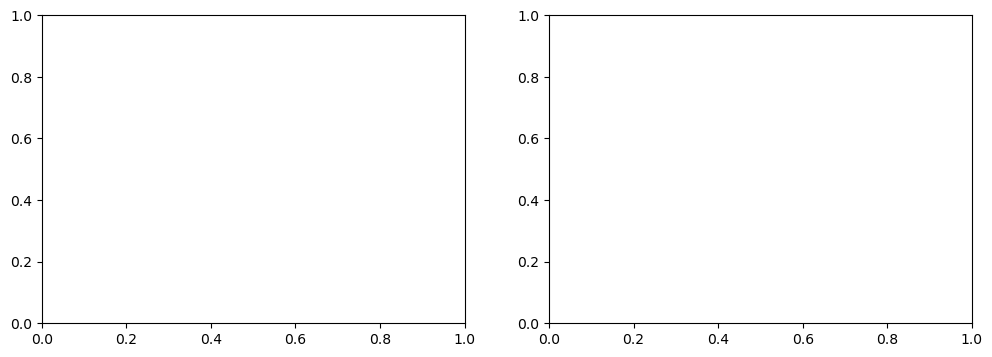

In [24]:
# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


In [25]:
# Pie chart
ax[0].pie([ham_count, spam_count], 
          labels=['Ham', 'Spam'], 
          autopct='%1.1f%%',
          colors=['#4CAF50', '#F44336'])
ax[0].set_title('Class Distribution')


Text(0.5, 1.0, 'Class Distribution')

In [26]:
# Bar chart
ax[1].bar(['Ham', 'Spam'], [ham_count, spam_count], 
          color=['#4CAF50', '#F44336'])
ax[1].set_title('Message Count')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [27]:
# Show sample messages
display(Markdown("### Sample Messages"))
sample_df = df.sample(5, random_state=42)[['label', 'text', 'label_binary']]
display(sample_df)

### Sample Messages

,label,text,label_binary
30,spam,Your Apple ID has been locked. Verify now to u...,1
126,spam,You have unread messages from celebrities,1
199,ham,Your car wash appointment is tomorrow,0
142,ham,Your online auction ends in 2 hours,0
254,ham,Can you check the weather for tomorrow?,0


In [28]:
# Split data
X = df['text']
y = df['label_binary']

In [29]:
print(f"Total samples: {len(X)}")

Total samples: 279


In [30]:
if len(X) < 20:
    print(" Error: Not enough data. Need at least 20 messages.")
    print("Please check your CSV file and try again.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # TF-IDF Vectorizer with adjusted parameters for small datasets
    max_features = min(1000, len(X))  # Don't exceed number of samples
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=1,  # Lower min_df for small datasets
        max_df=0.95
    )

    # Fit and transform
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    print(f" Training samples: {X_train_vec.shape[0]}")
    print(f" Testing samples: {X_test_vec.shape[0]}")
    print(f" Vocabulary size: {X_train_vec.shape[1]}")

    # Show some feature names
    print("\n📋 Sample features (words):")
    if hasattr(vectorizer, 'get_feature_names_out'):
        print(vectorizer.get_feature_names_out()[:20])
    else:
        print(vectorizer.get_feature_names()[:20])

 Training samples: 223
 Testing samples: 56
 Vocabulary size: 279

📋 Sample features (words):
['10' '100' '24' '24 hours' '50' '5000' 'account' 'activity' 'added'
 'added new' 'amazon' 'antivirus' 'app' 'app needs' 'apply' 'appointment'
 'arrived' 'art' 'available' 'backup']


In [31]:
# Dictionary to store models
models = {}

In [32]:
# Train Naive Bayes
print(" Training Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
models['naive_bayes'] = nb_model


 Training Naive Bayes...


In [33]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_vec, y_train)
models['logistic_regression'] = lr_model

print("Models trained successfully!")

Training Logistic Regression...
Models trained successfully!


In [70]:
print("\n Evaluating models...")


 Evaluating models...


In [72]:
results = {}


In [74]:
for model_name, model in models.items():
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score']
    }

In [76]:
print("Model Performance:")
for model_name, metrics in results.items():
    print(f"\n{model_name.upper()}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance:

NAIVE_BAYES:
  accuracy: 0.8214
  precision: 0.8180
  recall: 0.8214
  f1_score: 0.8147

LOGISTIC_REGRESSION:
  accuracy: 0.7679
  precision: 0.7698
  recall: 0.7679
  f1_score: 0.7415


In [78]:
print("\n Saving models...")


 Saving models...


In [80]:
model_package = {
    'vectorizer': vectorizer,
    'models': models,
    'label_mapping': {'ham': 0, 'spam': 1},
    'results': results,
    'best_model': 'naive_bayes'
}


In [82]:
import pickle
with open('spam_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Models saved as 'spam_model.pkl'")

Models saved as 'spam_model.pkl'


In [84]:
print("\n🔍 Creating prediction functions...")


🔍 Creating prediction functions...


In [86]:
def predict_spam(text, model_name='naive_bayes'):
    """Predict if text is spam"""
    with open('spam_model.pkl', 'rb') as f:
        model_data = pickle.load(f)
    
    vectorizer = model_data['vectorizer']
    models = model_data['models']
    
    text_vec = vectorizer.transform([text])
    prediction = models[model_name].predict(text_vec)[0]
    probabilities = models[model_name].predict_proba(text_vec)[0]
    
    return {
        "prediction": "spam" if prediction == 1 else "ham",
        "spam_probability": float(probabilities[1]),
        "ham_probability": float(probabilities[0]),
        "confidence": max(probabilities)
    }

In [88]:
# Test
test_message = "WINNER! You've won a $1000 gift card!"
result = predict_spam(test_message)
print(f"Test prediction: {result}")

Test prediction: {'prediction': 'spam', 'spam_probability': 0.6661055333046668, 'ham_probability': 0.33389446669533346, 'confidence': 0.6661055333046668}


In [90]:
print("\nCreating frontend module...")



Creating frontend module...


In [92]:
frontend_code = '''
import pickle

class SpamDetector:
    def __init__(self, model_path='spam_model.pkl'):
        with open(model_path, 'rb') as f:
            self.model_data = pickle.load(f)
    
    def predict(self, text, model='naive_bayes'):
        text_vec = self.model_data['vectorizer'].transform([text])
        prediction = self.model_data['models'][model].predict(text_vec)[0]
        probabilities = self.model_data['models'][model].predict_proba(text_vec)[0]
        
        return {
            "prediction": "spam" if prediction == 1 else "ham",
            "spam_probability": float(probabilities[1]),
            "ham_probability": float(probabilities[0])
        }
'''



In [96]:
with open('spam_detector.py', 'w') as f:
    f.write(frontend_code)

print(" Frontend module created")

 Frontend module created


In [98]:
print("\nGenerating test data...")


Generating test data...


In [100]:
# Create sample test data
test_data = pd.DataFrame({
    'message': [
        "Free gift card waiting for you!",
        "Meeting at 10 AM tomorrow",
        "Your account needs verification",
        "Lunch at the usual place?",
        "You won $5000! Click to claim",
        "Don't forget the meeting notes",
        "URGENT: Your computer has virus",
        "Can you pick up milk on the way home?"
    ],
    'expected': ['spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham']
})


In [102]:
test_data.to_csv('test_messages.csv', index=False)
print(" Test data saved as 'test_messages.csv'")


 Test data saved as 'test_messages.csv'


In [104]:
config = {
    "model_info": {
        "name": "Spam Detection Model",
        "version": "1.0",
        "created": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "models_trained": list(models.keys()),
        "best_model": model_package['best_model'],
        "accuracy": results[model_package['best_model']]['accuracy']
    },
    "dataset_info": {
        "total_samples": len(df),
        "ham_count": ham_count,
        "spam_count": spam_count,
        "training_samples": X_train_vec.shape[0],
        "testing_samples": X_test_vec.shape[0]
    }
}

In [106]:
with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)